#### Oriol Domingo Roig

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from stop_words import get_stop_words
from nltk.stem import SnowballStemmer

In [3]:
comments_df = pd.read_csv("data/jigsaw-toxic-comment-classification-challenge/train.csv")
comments_df.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0


This was done due to memory and cpu limitation of my laptop. However, it was only necessary when adding an extra layer to the RNN.

In [4]:
n = int(len(comments_df)/4)
comments_df = comments_df.iloc[1:n]
len(comments_df)

39891

In [5]:
label_colnames = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

X_train, X_test, y_train, y_test = \
    train_test_split(comments_df[['comment_text']], comments_df[label_colnames], random_state=667)
X_train.head(2)

,comment_text
3949,Hello \n\nI guess the reqeust for the lion vs ...
36054,"Also, you haven't said what information was de..."


In [6]:
comments_df = None # Free memory

The following class `TextPreprocessor` has been modified to allow processing '.' and ',' so then they can be *tokenized*. Moreover, `balanced_partition` allows increasing the amount of positive classes by setting a minimum frequency that each label should appear in our data.

In [7]:
BAD_SYMBOLS_RE = re.compile('[^0-9a-z .,]')
STEMMER = SnowballStemmer('english')

class TextPreprocessor:
        
    def transfrom_text(self, text):
        text = text.lower()
        text = re.sub(BAD_SYMBOLS_RE, " ", text) # process bad symbols
        # text = " ".join([STEMMER.stem(word) for word in text.split()])
        return text
    
    def transform(self, series):
        return series.apply(lambda text: self.transfrom_text(text))
    
    def labels_to_text(self, text, extra_labels):
        for idx in extra_labels.index:
            aux = text.loc[[idx]]
            text = text.append(aux.iloc[[0]])
        return text    
    
    def over_sampling(self,text,labels,extra_positive):
        extra_labels = pd.DataFrame()
        for idx in range(len(extra_positive)):
            target = extra_positive[idx]
            if idx == 0:
                extra_labels = labels.groupby([target]).get_group(1)
            else:
                prev_target = extra_positive[idx-1]
                extra_labels = extra_labels[extra_labels[target] == extra_labels[prev_target]]
        
        labels = labels.append(extra_labels)
        text = self.labels_to_text(text,extra_labels)

        return text,labels
    
    def balanced_partition(self,text,labels,min_freq):
        while True :
            labels_dist = labels.sum()/len(labels)
            extra_positive = []
            for label in labels_dist.keys():
                if labels_dist[label] < min_freq:
                    extra_positive.append(label) 
            if len(extra_positive) == 0: 
                return text,labels
            else: 
                text,labels = self.over_sampling(text,labels,extra_positive)
        

In [9]:
y_train.sum()/len(y_train)

toxic            0.097232
severe_toxic     0.010763
obscene          0.052376
threat           0.003443
insult           0.049535
identity_hate    0.008991
dtype: float64

In [10]:
preprocessor = TextPreprocessor()
X_train_trs = preprocessor.transform(X_train['comment_text'])
X_train_preprocessed, y_train = preprocessor.balanced_partition(X_train_trs,y_train,0.02)
X_test_preprocessed = preprocessor.transform(X_test['comment_text'])

In [19]:
print(X_train["comment_text"].iloc[0])
print('---------------------------------------------------------------------------------------------------------------------')
print(X_train_preprocessed.iloc[0])

Hello 

I guess the reqeust for the lion vs tiger consenses I asked of Keith, will be  adressed to you:

https://en.wikipedia.org/wiki/User_talk:Keithbob

So if you may: 

Thanks: ^_^
---------------------------------------------------------------------------------------------------------------------
hello   i guess the reqeust for the lion vs tiger consenses i asked of keith, will be  adressed to you   https   en.wikipedia.org wiki user talk keithbob  so if you may    thanks     


In [11]:
y_train.sum()/len(y_train),len(X_train_preprocessed),len(y_train)

(toxic            0.114023
 severe_toxic     0.029162
 obscene          0.070002
 threat           0.021978
 insult           0.067213
 identity_hate    0.027423
 dtype: float64, 30485, 30485)

In [12]:
X_train_trs = None # Free memory
X_train = None     # Free memory
X_test = None      # Free memory

Function `create_dicts` reduces vocabulary size by eliminating those words that appears less than *min_count* or that they are considered as *STOP_WORDS* in english. If '.' and ',' are found, they are mapped to `<dot>` and `<coma>` respectively. It was necessary to handle '.' and ',', this is why in `Tokenizer` I have add a convert function that allows to correctly map dots and comas.

In [13]:
STOP_WORDS = get_stop_words('en')

def create_dicts(text, min_count = 1):
    
    word_dict = {}
    words = text.split()
   
    for word in words:
        word_dict[word] = word_dict.get(word,0) + 1
        
    frequent_words = []
    
    for key, value in word_dict.items():
        if value >= min_count and key not in STOP_WORDS:
            if key == '.': key = '<dot>'
            elif key == ',': key = '<coma>'
            frequent_words.append(key)
            
    word_list = ["<UNK>", "<PAD>"] + sorted(frequent_words)
    
    word2idx = {word_list[idx]: idx for idx in range(len(word_list))}
    idx2word = {idx: word_list[idx] for idx in range(len(word_list))}
    return word2idx, idx2word

class Tokenizer:
    
    def __init__(self):
        self.word2idx = None
        self.idx2word = None
        
    def fit(self, X,min_count):
        text = " ".join(X)
        self.word2idx, self.idx2word = create_dicts(text,min_count)
    
    def transform(self, X):
        return [self.transform_line(line) for line in X]
        
    def transform_line(self, line):
        return [self.word2idx.get(self.convert(word), 0) for word in line.split()]
    
    def convert(self,word):
            if word == '.': word = '<dot>'
            elif word == ',': word = '<coma>'
            return word

In [14]:
tokenizer = Tokenizer()
tokenizer.fit(X_train_preprocessed,3)

In [15]:
X_train_tokenized = tokenizer.transform(X_train_preprocessed)
X_test_tokenized = tokenizer.transform(X_test_preprocessed)

In [16]:
X_train_preprocessed = None  # Free memory
X_test_preprocessed = None   # Free memory

In [17]:
class Cutter:

    def __init__(self, size=150):
        self.size = size
        
    def transform(self, X):
        new_X = []
        for line in X:
            new_line = line[:self.size]
            new_line = new_line + [1] * (self.size - len(new_line))
            new_X.append(new_line)
        return new_X   

In [18]:
cutter = Cutter()
X_train_cutted = cutter.transform(X_train_tokenized)
X_test_cutted = cutter.transform(X_test_tokenized)

In [19]:
X_train_tokenized = None   # Free memory
X_test_tokenized = None    # Free memory

In [20]:
labels = torch.from_numpy(y_train.values)
labels

tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        ...,
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1]])

In [21]:
train_data = TensorDataset(torch.tensor(X_train_cutted), torch.from_numpy(y_train.values).float())
test_data = TensorDataset(torch.tensor(X_test_cutted), torch.from_numpy(y_test.values).float())

batch_size = 32

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=len(test_data))

In [22]:
class LSTMModel(nn.Module):
    
    def __init__(self, dict_size, output_size, embedding_dim, hidden_dim, hidden_inter_dim):
        super().__init__()
        self.embedding = nn.Embedding(dict_size, embedding_dim)
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_inter_dim, batch_first=True)
        self.fc = nn.Linear(hidden_inter_dim, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        embeded = self.embedding(x)
        lstm_out, _ = self.lstm1(embeded)
        #lstm_out = lstm_out[:, -1] 
        lstm_outer,_ = self.lstm2(lstm_out)
        lstm_outer = lstm_outer[:,-1]
        logits = self.fc(lstm_outer)
        out = self.sigmoid(logits)
        return out

In [23]:
dict_size = len(tokenizer.word2idx)
output_size = len(label_colnames)
embedding_dim = 3
hidden_dim = 4
hidden_inter_dim = 3

lstm_model = LSTMModel(dict_size, output_size, embedding_dim, hidden_dim,hidden_inter_dim)

In [24]:
dataiter = iter(train_loader)
input_data, labels = dataiter.next()
lstm_model(input_data)

tensor([[0.6134, 0.4585, 0.4685, 0.5976, 0.4615, 0.3925],
        [0.6134, 0.4585, 0.4685, 0.5976, 0.4615, 0.3925],
        [0.6134, 0.4585, 0.4685, 0.5976, 0.4615, 0.3925],
        [0.6134, 0.4585, 0.4685, 0.5976, 0.4615, 0.3925],
        [0.6134, 0.4585, 0.4685, 0.5976, 0.4615, 0.3925],
        [0.6134, 0.4585, 0.4685, 0.5976, 0.4615, 0.3925],
        [0.6134, 0.4585, 0.4685, 0.5976, 0.4615, 0.3925],
        [0.6134, 0.4585, 0.4685, 0.5976, 0.4615, 0.3925],
        [0.6134, 0.4585, 0.4685, 0.5976, 0.4615, 0.3925],
        [0.6134, 0.4585, 0.4685, 0.5976, 0.4615, 0.3925],
        [0.6134, 0.4585, 0.4685, 0.5976, 0.4615, 0.3925],
        [0.6134, 0.4585, 0.4685, 0.5976, 0.4615, 0.3925],
        [0.6134, 0.4585, 0.4685, 0.5976, 0.4615, 0.3925],
        [0.6134, 0.4585, 0.4685, 0.5976, 0.4615, 0.3925],
        [0.6134, 0.4585, 0.4685, 0.5976, 0.4615, 0.3925],
        [0.6134, 0.4585, 0.4685, 0.5976, 0.4615, 0.3925],
        [0.6134, 0.4585, 0.4685, 0.5976, 0.4615, 0.3925],
        [0.613

In [25]:
lr = 0.05
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr)

In [26]:
n_epoch = 4
print_every = 300

lstm_model.train()
optimizer.train = True

loss_over_time = [] # to track the loss as the network trains
    
for epoch in range(n_epoch):
    
    running_loss = 0.0
    
    for batch_i, (input_data, labels) in enumerate(train_loader):
        # Zero gradients (just in case)
        optimizer.zero_grad()

        # Forward pass, calculate predictions
        output = lstm_model(input_data) 
        # Calculate loss
        loss = criterion(output, labels)
        ## Backward propagation
        loss.backward()
        ## Upade weights
        optimizer.step()
        
        # print loss statistics
        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()

        if batch_i % print_every ==  print_every - 1:    # print everyx batches (
                avg_loss = running_loss/print_every
                # record and print the avg loss over the 100 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, avg_loss))
                running_loss = 0.0

print('Finished Training')

Epoch: 1, Batch: 300, Avg. Loss: 0.21438441023230553
Epoch: 1, Batch: 600, Avg. Loss: 0.20713056550671657
Epoch: 1, Batch: 900, Avg. Loss: 0.19493156573424736
Epoch: 2, Batch: 300, Avg. Loss: 0.19825190457204978
Epoch: 2, Batch: 600, Avg. Loss: 0.1915242950618267
Epoch: 2, Batch: 900, Avg. Loss: 0.1985955570762356
Epoch: 3, Batch: 300, Avg. Loss: 0.2075862596432368
Epoch: 3, Batch: 600, Avg. Loss: 0.20558393610020478
Epoch: 3, Batch: 900, Avg. Loss: 0.19684397413084903
Epoch: 4, Batch: 300, Avg. Loss: 0.1948415905609727
Epoch: 4, Batch: 600, Avg. Loss: 0.19865096479654312
Epoch: 4, Batch: 900, Avg. Loss: 0.20518127150833607
Finished Training


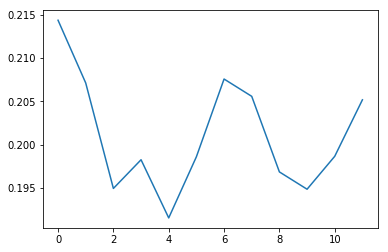

In [27]:
plt.plot(loss_over_time)
plt.show()

In the following list there is a record of the results obtained playing with some parameters as well as adding an extra layer:


1. Type : LSTM-MLP   ; Embeding: 3 ; Hidden Dim : 4   ; Epochs : 1  ; LR : 0.005 ; Avg Loss : 0.167 
2. Type : LSTM-MLP   ; Embeding: 4 ; Hidden Dim : 4   ; Epochs : 1  ; LR : 0.005 ; Avg Loss : 0.173
3. Type : LSTM-MLP   ; Embeding: 3 ; Hidden Dim : 2   ; Epochs : 1  ; LR : 0.005 ; Avg Loss : 0.171
4. Type : LSTM-MLP   ; Embeding: 3 ; Hidden Dim : 3   ; Epochs : 1  ; LR : 0.005 ; Avg Loss : 0.174
5. Type : 2xLSTM-MLP ; Embeding: 3 ; Hidden Dim : 4-3 ; Epochs : 4  ; LR : 0.05  ; Avg Loss : 0.116
6. Type : 2xLSTM-MLP ; Embeding: 3 ; Hidden Dim : 3-4 ; Epochs : 4  ; LR : 0.05  ; Avg Loss : 0.201
7. Type : 2xLSTM-MLP ; Embeding: 2 ; Hidden Dim : 4-3 ; Epochs : 4  ; LR : 0.05  ; Avg Loss : 0.205

In [28]:
def evaluate_classification(y, y_hat, y_proba):
    return {
        "Accuracy": accuracy_score(y, y_hat),
        "Precision": precision_score(y, y_hat),
        "Recall": recall_score(y, y_hat),
        "F1-score": f1_score(y, y_hat),
        "AUC": roc_auc_score(y, y_proba),
    }

In [29]:
import numpy as np
num_classes = len(label_colnames)
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))

# set the module to evaluation mode
lstm_model.eval()

# get the input images and their corresponding labels
inputs, labels = test_loader.dataset.tensors

# forward pass to get outputs
outputs = lstm_model(inputs)

# calculate the loss
loss = criterion(outputs, labels)

# update average test loss 
test_loss = test_loss + ((torch.ones(1) / (len(labels) + 1)) * (loss.data - test_loss))

# get the predicted class from the maximum value in the output-list of class scores
metrics = {}
for j in range(num_classes):
    # compare predictions to true label
    predicted_class = np.round(outputs.data[:,j])
    labels_class = labels.data[:,j]
    class_total[j] = len(labels)
    class_correct[j] = (labels_class==predicted_class).sum()
    metrics[label_colnames[j]] = evaluate_classification(labels_class, predicted_class, outputs.data[:,j])
    #(predicted_class == labels_class).sum()
              
print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

Test Loss: 0.000015



/home/oriol/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/oriol/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/oriol/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/oriol/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/oriol/.local/lib/python3.5/site-packages/sklearn/metrics/classific

In [30]:
for label in metrics:
    print(label)
    print(metrics[label])

insult
{'Accuracy': 0.9488619272034493, 'AUC': 0.49832381224707994, 'Recall': 0.0, 'F1-score': 0.0, 'Precision': 0.0}
identity_hate
{'Accuracy': 0.9908753634813998, 'AUC': 0.5032120783486904, 'Recall': 0.0, 'F1-score': 0.0, 'Precision': 0.0}
severe_toxic
{'Accuracy': 0.9896721147097163, 'AUC': 0.5079888059334454, 'Recall': 0.0, 'F1-score': 0.0, 'Precision': 0.0}
obscene
{'Accuracy': 0.9444500150406097, 'AUC': 0.5033525445725151, 'Recall': 0.0, 'F1-score': 0.0, 'Precision': 0.0}
toxic
{'Accuracy': 0.8971222300210568, 'AUC': 0.5019210486009119, 'Recall': 0.0, 'F1-score': 0.0, 'Precision': 0.0}
threat
{'Accuracy': 0.9968916073398175, 'AUC': 0.5031683765841883, 'Recall': 0.0, 'F1-score': 0.0, 'Precision': 0.0}


In the following list there is a record of the performances metrics obtained in the test set regarding methods described above. Each reference number corresponds to the model assigned with the same number.

1. Test Loss : 0.000004 ; Accuracy : 0.9608 ; Precision : 0.433
2. Test Loss : 0.000004 ; Accuracy : 0.9605 ; Precision : 0.361
3. Test Loss : 0.000004 ; Accuracy : 0.9623 ; Precision : 0.0
4. Test Loss : 0.000004 ; Accuracy : 0.9630 ; Precision : 0.291
5. Test Loss : 0.000013 ; Accuracy : 0.9615 ; Precision : 0.375
6. Test Loss : 0.000015 ; Accuracy : 0.9597 ; Precision : 0.223
7. Test Loss : 0.000015 ; Accuracy : 0.9571 ; Precision : 0.0